In [59]:
import numpy as np
from scipy import stats
from sklearn import mixture # http://scikit-learn.org/stable/modules/mixture.html
from scipy import linalg

# Simulated Dataset 1

In [ ]:
def measure(n):
    m1 = np.random.normal(size=n)
    m2 = np.random.normal(scale=0.5, size=n)
    return m1+m2, m1-m2

m1, m2 = measure(2000)

## Meshgrid for density plot

In [45]:
xmin, xmax = m1.min(), m1.max()
ymin, ymax = m2.min(), m2.max()
print(xmin, xmax, ymin, ymax)

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])

-3.6467157394 4.04421277504 -3.13999514074 4.49266550156


## Gaussian KDE

In [46]:
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

# resample from the estimated pdf
assert kernel.d == np.vstack([m1,m2]).shape[0]
X2, y2 = kernel.resample(100)

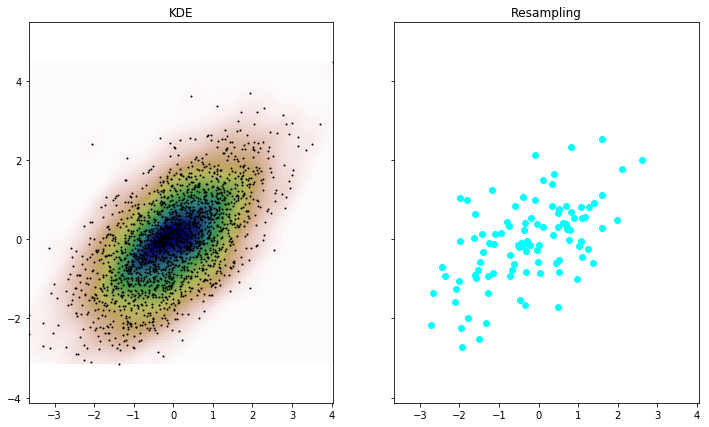

In [48]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1,ncols=2, sharey=True, sharex=True, figsize=(12,7))
ax[0].imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[xmin,xmax,ymin,ymax])
ax[0].plot(m1,m2,'k.',markersize=2)
ax[0].set_xlim([xmin,xmax])
ax[0].set_ylim([ymin,ymax])
ax[0].set_title('KDE')

ax[1].scatter(X2.ravel(),y2.ravel(),c='cyan')
ax[1].set_title('Resampling')
plt.show()

## Gaussian Mixture Model
We use Bayesian Information Criterion (BIC) for selecting the number of components of our mixture model.

In [106]:
import itertools

X = values.T

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                     covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

In [107]:
bic = np.array(bic) 
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue','darkorange'])
clf = best_gmm
bars = []

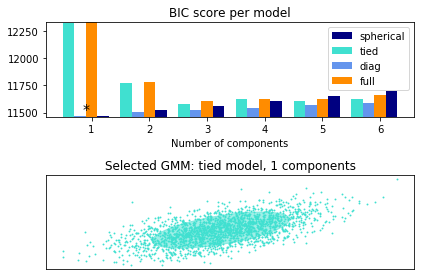

In [114]:
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
X = values.T
Y_ = clf.predict(X)

n_features = X.shape[1]

covariances = []
for i in range(len(clf.means_)):
    if clf.covariance_type == 'full':
        covariances.append(clf.covariances_[i][:n_features, :n_features])
    elif clf.covariance_type == 'tied':
        covariances.append(clf.covariances_[:n_features, :n_features])
    elif clf.covariance_type == 'diag':
        covariances.append(np.diag(clf.covariances_[i][:n_features]))
    elif clf.covariance_type == 'spherical':
        covariances.append(np.eye(n_features) * clf.covariances_[i])


for i, (mean, cov, color) in enumerate(zip(clf.means_, covariances,
                                           color_iter)):

    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: %s model, %s components'%(clf.covariance_type, len(clf.means_)))
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.tight_layout()
plt.show()